# Mask R-CNN - Inspect BeeTrained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [141]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
#ROOT_DIR = os.path.abspath("../../")
#ROOT_DIR = "/home/beltus/image/Instance-Segmentation-MaskRCNN-master/logs/bee20200629T1118"

ROOT_DIR = "/home/beltus/image/Bees/"
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.bee import bee

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = "/home/beltus/image/Bees/samples/bee/mask_rcnn_bee_0038.h5"

#BALLON_WEIGHTS_PATH = "/home/beltus/image/Instance-Segmentation-MaskRCNN-master/logs/bee20200629T1118/mask_rcnn_bee_00028.h5"  # TODO: update this path

In [142]:
#masked R-CNN model works on Tensorflow version 1
import tensorflow 
print(tensorflow.__version__)


1.13.1


## Configurations

In [143]:
config = bee.CustomConfig()
BALLOON_DIR = "/home/beltus/image/Bees/samples/bee/dataset"

In [144]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [145]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [146]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [76]:
# Load validation dataset
dataset = bee.CustomDataset()
dataset.load_custom(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 9
Classes: ['BG', 'bee']


## Load Model

In [77]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [78]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = BALLON_WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/beltus/image/Bees/samples/bee/mask_rcnn_bee_0038.h5


## Run Detection

7
image ID: bee.bee68.jpg (7) /home/beltus/image/Bees/samples/bee/dataset/val/bee68.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  293.00000  max:  576.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


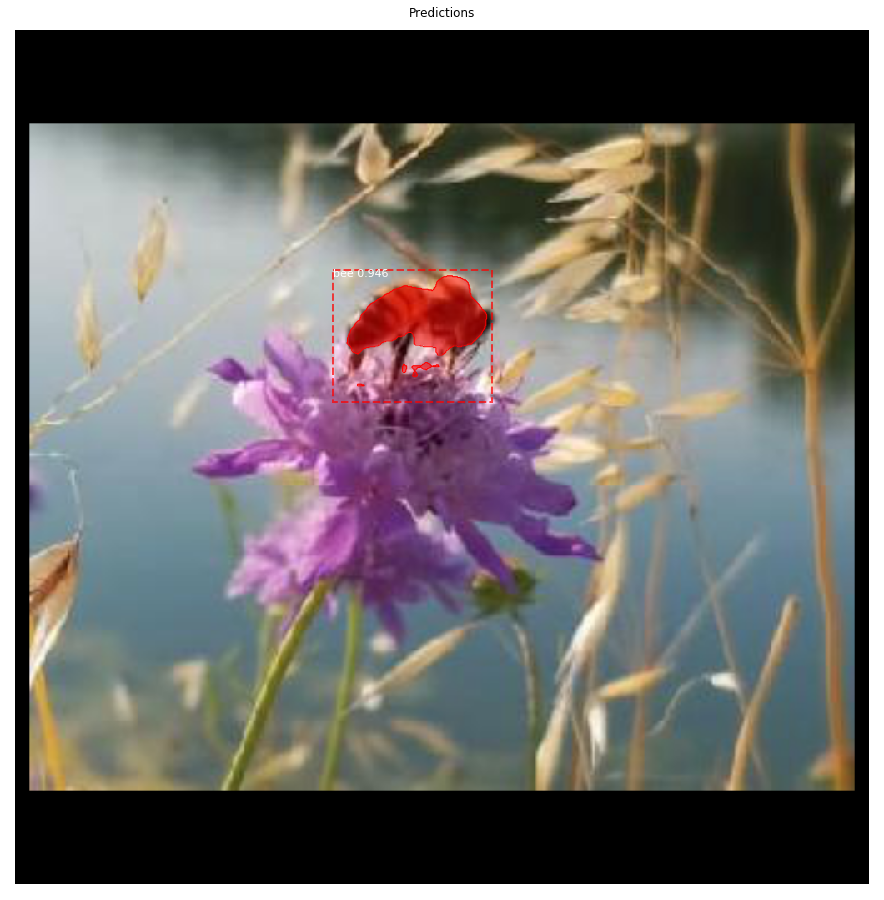

In [87]:
image_id = 7

#image_id = random.choice(dataset.image_ids)

print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [94]:
img = image

im = cv2.cvtColor(img , cv2.COLOR_RGB2BGR)

cv2.imwrite("/home/beltus/image/Bees/samples/bee/dataset/val/origin.jpg" , im)


True

8
image ID: bee.bee70.jpg (8) /home/beltus/image/Bees/samples/bee/dataset/val/bee70.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 

gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  377.00000  max:  581.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


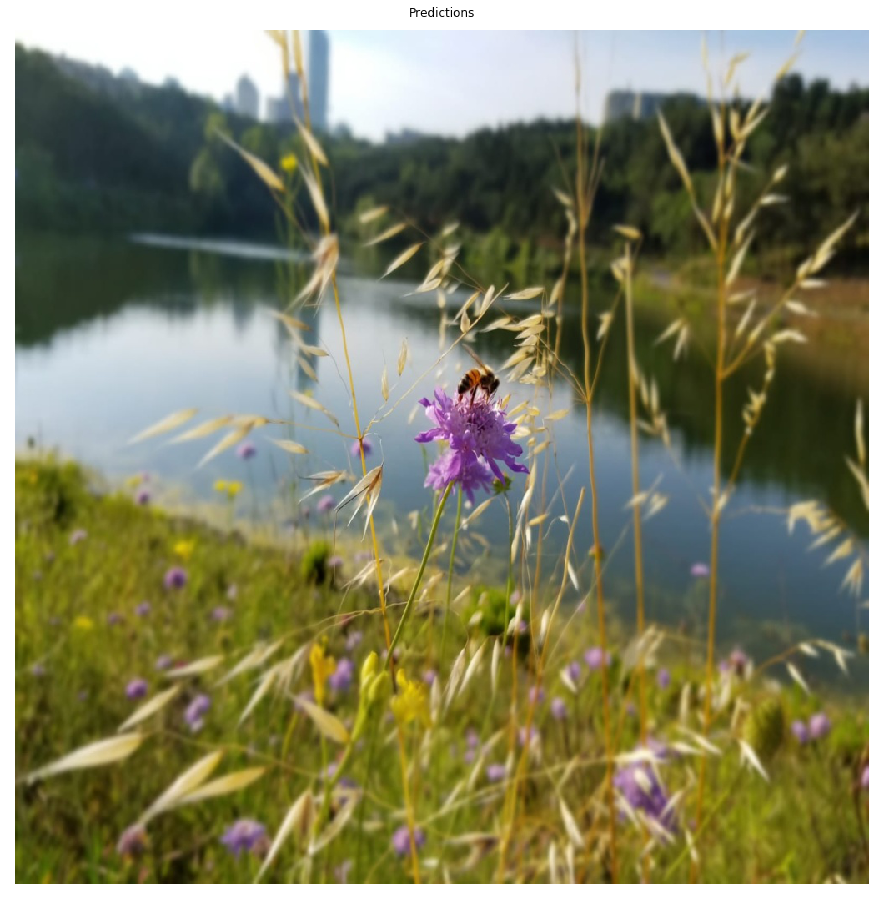

In [81]:
image_id = 8

#image_id = random.choice(dataset.image_ids)

print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


In [101]:

mask = r['masks']

img = mask[2]

img.shape

(1024, 1)

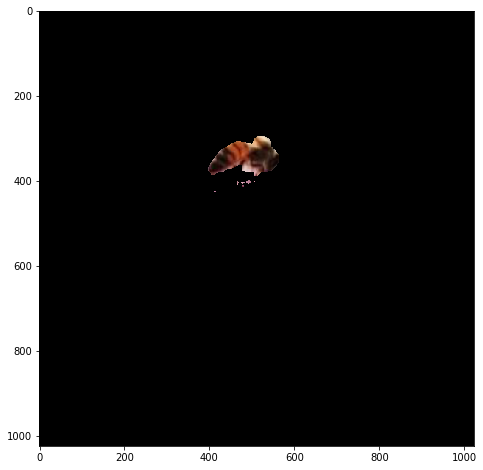

In [104]:
import skimage.io
for i in range(mask.shape[2]):
    temp = image
    
    #dim = (1024, 1024)
 
# resize image
    #temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)
    
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)


(<Figure size 576x576 with 1 Axes>,
 Text(0.5, 1.0, 'Segmented Image'),
 <matplotlib.image.AxesImage at 0x7f06d837d128>)

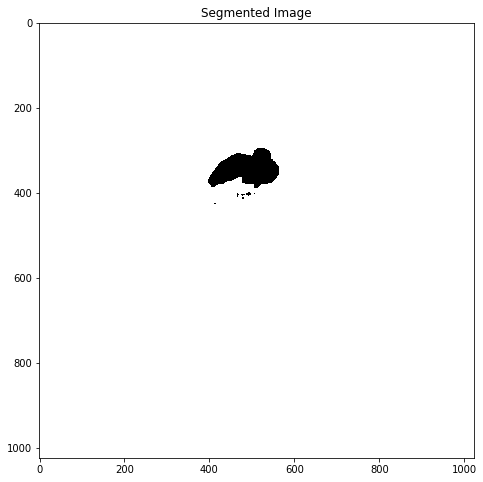

In [118]:
#ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
#plt.figure(figsize = (8,8)) , plt.title("Ground Truth") , plt.imshow(thresh1 , cmap = "gray")

#convert segmented image to gray
gray = cv2.cvtColor(temp , cv2.COLOR_BGR2GRAY)

#perform inverse binary thresholding
ret,thresh1 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV)

plt.figure(figsize = (8,8)) , plt.title("Segmented Image") , plt.imshow(thresh1 , cmap = "gray")


(<Figure size 576x576 with 1 Axes>,
 Text(0.5, 1.0, 'Ground Truth'),
 <matplotlib.image.AxesImage at 0x7f0737e36668>)

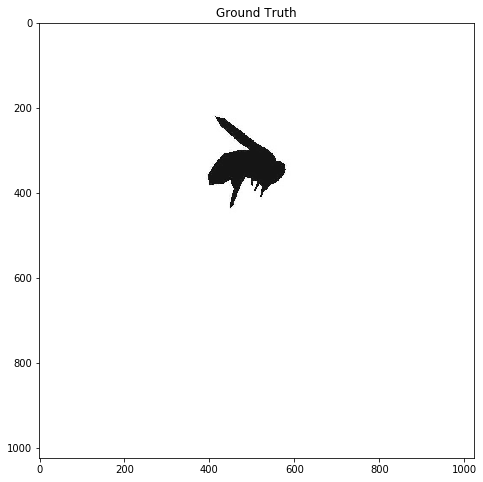

In [135]:
#read in the ground truth mask
mask = cv2.imread("/home/beltus/image/Bees/samples/bee/dataset/val/mask1.jpg")

graymask = cv2.cvtColor(mask , cv2.COLOR_BGR2GRAY)
#ret,threshmask = cv2.threshold(graymask,0,255,cv2.THRESH_BINARY_INV)#print(max(mask))
plt.figure(figsize = (8,8)) , plt.title("Ground Truth") , plt.imshow(graymask , cmap = "gray")
#np.max(graymask)
#graymask.shape

## Intersection over Union

In [140]:
target = graymask
prediction = thresh1

#compute intersection over union
intersection = np.logical_and(target, prediction)
union = np.logical_or(target, prediction)

#compute to 2 decimal places
iou_score = round(np.sum(intersection) / np.sum(union) * 100 , 2) 
print("The Intersection over Union Score = " + str(iou_score) + "%")

The Intersection over Union Score = 99.03%


In [103]:
d = "/home/beltus/image/Bees/samples/bee/dataset/val/ITU_Golet_Ari.jpeg"

rim = cv2.imread(d)

h , w, _ = rim.shape
dim = (int(h/2), int(w/2))
re = cv2.resize(rim , dim , interpolation = cv2.INTER_AREA)

cv2.imwrite("/home/beltus/image/Bees/samples/bee/dataset/val/resize.jpg" , re)


True

4
image ID: bee.bee61.jpg (4) /home/beltus/image/Bees/samples/bee/dataset/val/bee61.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   45.00000  max:  735.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


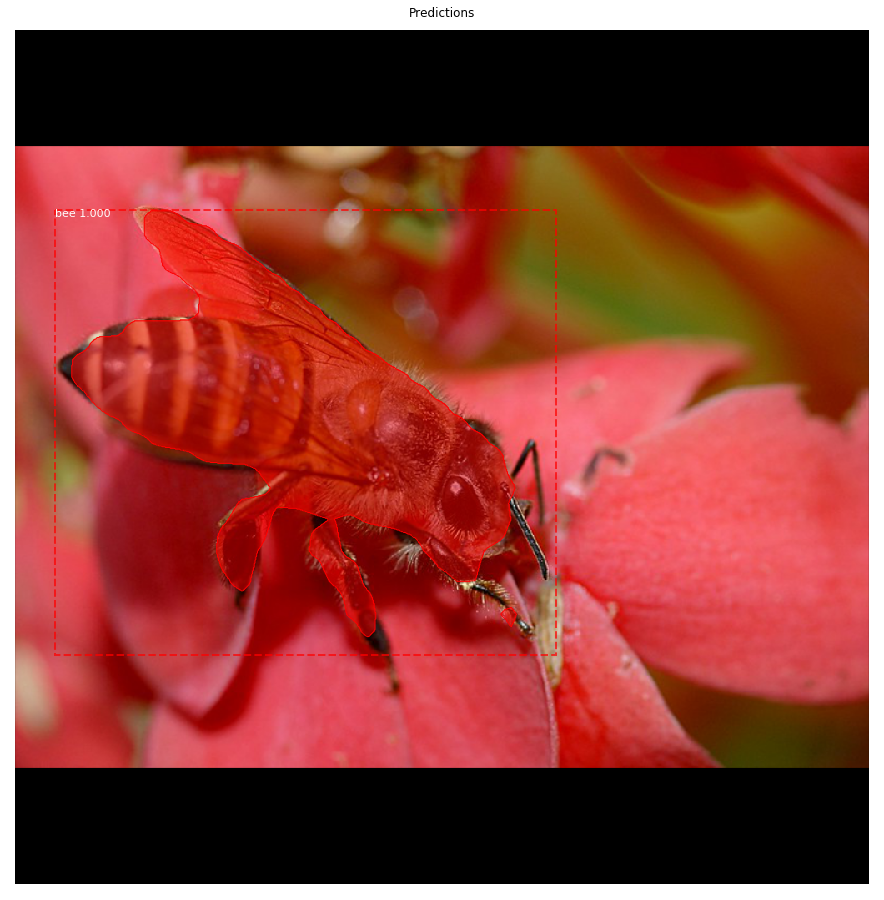

In [60]:
image_id = random.choice(dataset.image_ids)

print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

#im = "/home/beltus/image/Instance-Segmentation-MaskRCNN-master/ITU_Golet_Ari.jpeg"

#im = "/home/beltus/image/Instance-Segmentation-MaskRCNN-master/bes.jpg"

#import cv2
#image = cv2.imread(im)

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [59]:
mask = r['masks']
mask = mask.astype(int)
mask.shape

(1024, 1024, 1)

In [44]:
import skimage.io
for i in range(mask.shape[2]):
    temp = skimage.io.imread('sample.jpg')
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)

FileNotFoundError: No such file: '/home/beltus/image/Bees/samples/bee/sample.jpg'